In [312]:
import matplotlib.pyplot as plt
from matplotlib import rcParams, cm
import numpy as np
from scipy.signal import stft, resample, welch
from scipy.fft import fft, ifft
from scipy import signal
from copy import deepcopy as dc

In [313]:
def butter_bandpass(data, lowcut, highcut, fs=200, order=4):
    nyq = fs * 0.5
    low = lowcut / nyq
    high = highcut / nyq
    b, a = signal.butter(order, [low, high], btype='bandpass')
    return signal.filtfilt(b, a, data)

In [314]:
# Imprime os gráficos
def print_graphs(datas):
    rcParams['figure.figsize'] = [16., 10.]

    x = np.linspace(0, 8, 1600)
    fig, ax = plt.subplots(len(datas), 1)

    for i in range(len(datas)):
        for j in range(4):
            ax[i].plot(x, datas[i,j])

    plt.show()

In [315]:
def print_3d_graphs(data):
    rcParams['figure.figsize'] = [18., 6.]

    for trial in (0, 1):
        mov = 1
        plot_data = []
        for channel in range(2):
            # espaço de 1600 pontos entre 0 e 1
            for i, t in enumerate(np.linspace(0, 1, 1600)):
                plot_data.append([channel, t, data[mov][trial][channel][i]])

        plot_data = np.array(plot_data)
        x, y, z = plot_data[:,0], plot_data[:,1], plot_data[:,2]
        ax = plt.axes(projection ='3d')
        ax.set_title('Movimento {}'.format(mov + 1))
        ax.set_xlabel('Canais')
        ax.set_ylabel('Tempo (s)')
        ax.set_zlabel('Potência (mV)')
        ax.plot_trisurf(x, y, z, antialiased=True, cmap=cm.inferno, linewidth=1)
        plt.show()

In [316]:
data1 = np.load('datasets/topicos_cc/s10_1.npy')
data2 = np.load('datasets/topicos_cc/s10_2.npy')
data3 = np.load('datasets/topicos_cc/s10_3.npy')

data = np.array([data1, data2, data3])
data = data.swapaxes(0, 1)
data = data.swapaxes(2, 3)

print(data.shape)

data = butter_bandpass(data, 5, 50)

(8, 3, 4, 1600)


In [317]:
# Dados de mesma classe e diferentes ensaios
# [classes, ensaios, canais, : ]
d1 = data[0,0,0,:], data[0,0,1,:], data[0,0,2,:], data[0,0,3,:]
d2 = data[0,1,0,:], data[0,1,1,:], data[0,1,2,:], data[0,1,3,:]
d3 = data[0,2,0,:], data[0,2,1,:], data[0,2,2,:], data[0,2,3,:]

datas = np.array([d1, d2, d3])

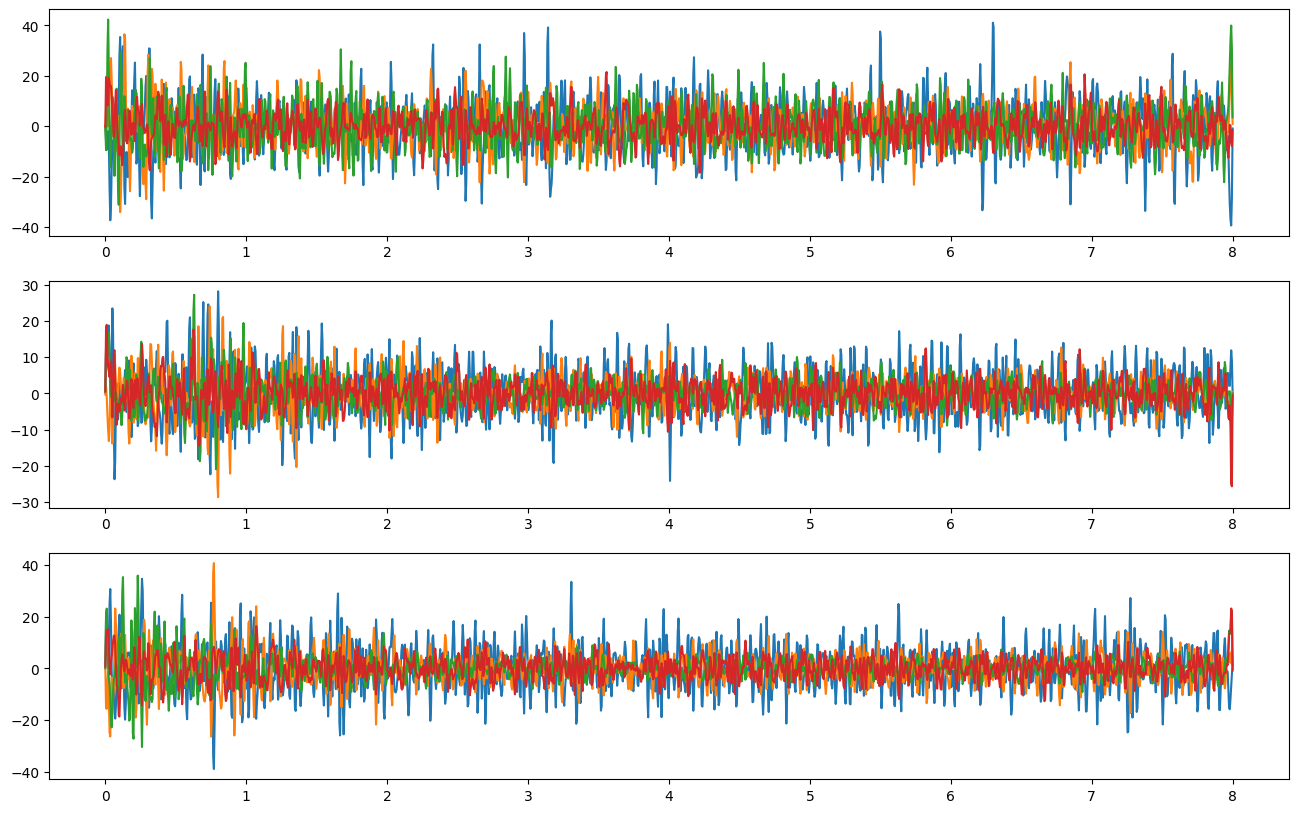

In [318]:
print_graphs(datas)

In [319]:
# Dados de diferentes classes e mesmo ensaio
# [classes, ensaios, canais, : ]
d1 = data[0,0,0,:], data[0,0,1,:], data[0,0,2,:], data[0,0,3,:]
d2 = data[1,0,0,:], data[1,0,1,:], data[1,0,2,:], data[1,0,3,:]
d3 = data[2,0,0,:], data[2,0,1,:], data[2,0,2,:], data[2,0,3,:]
d4 = data[3,0,0,:], data[3,0,1,:], data[3,0,2,:], data[3,0,3,:]
d5 = data[4,0,0,:], data[4,0,1,:], data[4,0,2,:], data[4,0,3,:]
d6 = data[5,0,0,:], data[5,0,1,:], data[5,0,2,:], data[5,0,3,:]
d7 = data[6,0,0,:], data[6,0,1,:], data[6,0,2,:], data[6,0,3,:]
d8 = data[7,0,0,:], data[7,0,1,:], data[7,0,2,:], data[7,0,3,:]

datas2 = np.array([d1, d2, d3, d4, d5, d6, d7, d8])

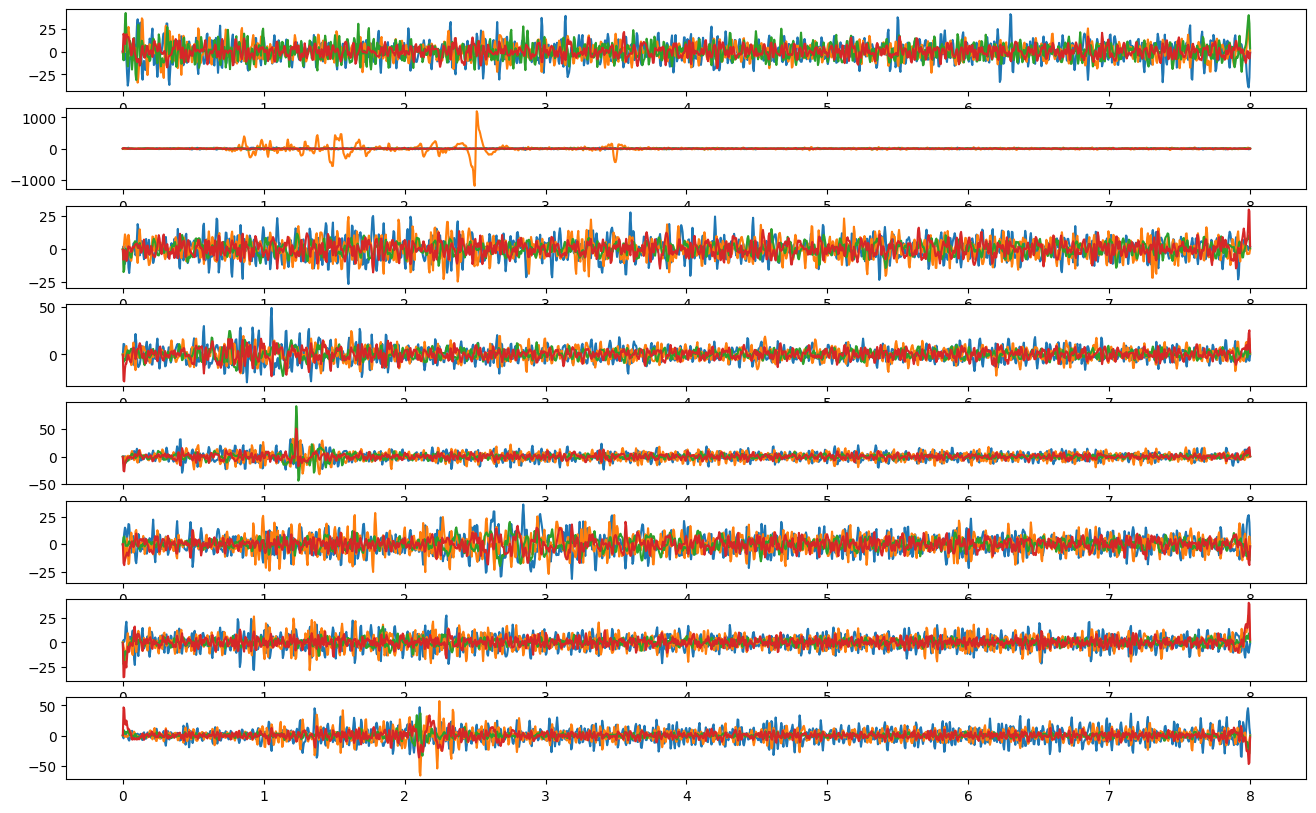

In [320]:
print_graphs(datas2)

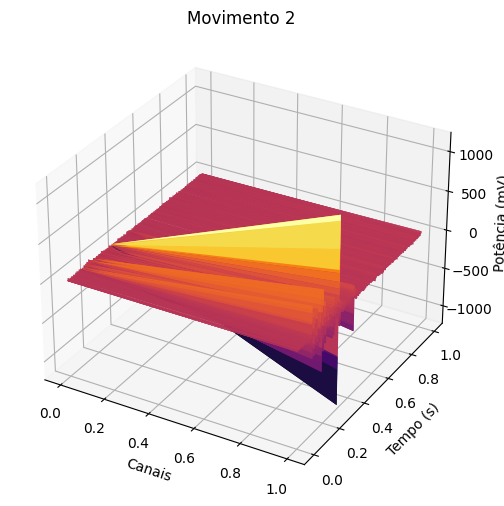

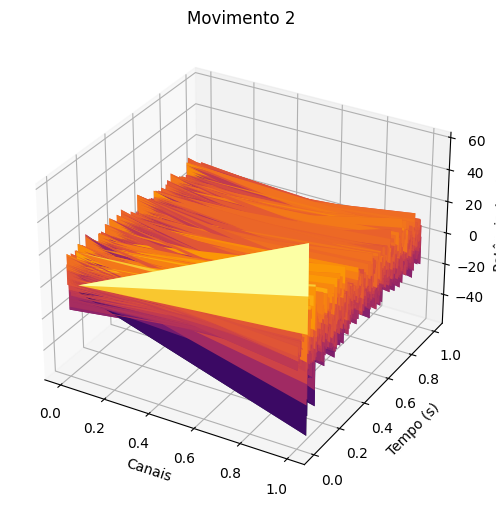

In [321]:
print_3d_graphs(data)

In [322]:
from scipy.signal import stft

step = 48
segment = 64
print('', data.shape)
dataR = data.reshape(24, 4, 1600)
print('', dataR.shape)

n_win = int((dataR.shape[-1] - segment) / step) + 1
ids = np.arange(n_win) * step

# Janelas do dado no dominio do tempo
chunks_time = np.array([dataR[:,:,k:(k + segment)] for k in ids]).transpose(1, 2, 0, 3)

# Janelas do dado no domínio da frequência
_, _, chunks_freq = stft(dataR, fs=200, nperseg=128, noverlap=78)
chunks_freq = np.swapaxes(chunks_freq, 2, 3)

f, chunks_welch = welch(dataR, fs=200, nperseg=64, noverlap=32)

print('Formato (shape) dos dados depois da divisão de janelas')
print(f'Dominio do tempo: {chunks_time.shape} - (classes+ensaios, canais, janelas, linhas)')
print(f'Dominio da frequência:  {chunks_freq.shape} - (classes+ensaios, canais, janelas, linhas)')
print(f'Dominio da frequência (welch):  f: {f.shape}, chunks_welch: {chunks_welch.shape} - (classes+ensaios, canais, janelas, linhas)')

 (8, 3, 4, 1600)
 (24, 4, 1600)
Formato (shape) dos dados depois da divisão de janelas
Dominio do tempo: (24, 4, 33, 64) - (classes+ensaios, canais, janelas, linhas)
Dominio da frequência:  (24, 4, 33, 65) - (classes+ensaios, canais, janelas, linhas)
Dominio da frequência (welch):  f: (33,), chunks_welch: (24, 4, 33) - (classes+ensaios, canais, janelas, linhas)


In [323]:
# funções auxiliares
def PSD(w):
    ''' definição da função PSD para o sinal no domínio da frequência '''
    return np.abs(w) ** 2

def var(x):
    return np.sum(x ** 2, axis=-1) / (np.prod(x.shape) - 1)

def rms(x):
    return np.sqrt(np.sum(np.abs(x) ** 2, axis=-1) / (np.prod(x.shape) - 1))

def fmd(w):
    return np.sum(PSD(w), axis=-1) / 2

def mmdf(w):
    return np.sum(np.abs(w), axis=-1) / 2

def wamp(w, threshold=0):
    differences = np.abs(np.diff(w))
    wamp_count = np.sum(differences >= threshold, axis=-1)

    return wamp_count

def wl(w):
    differences = np.diff(w)
    wl = np.sum(np.abs(differences), axis=-1)
    return wl

def zc(w):
    crossings = np.sum(np.diff(np.sign(w)) != 0, axis=-1)
    return crossings

def fmn(w):
    fmn = np.mean(w, axis=-1)
    return fmn

def mmnf(x):
    unique_values, counts = np.unique(x, return_counts=True, axis=-1)
    return np.sum(unique_values * counts, axis=-1) / np.sum(counts)


In [325]:
final_data = list()
final_data.append(chunks_welch)
final_data.append(var(chunks_time))
final_data.append(rms(chunks_time))
final_data.append(fmd(chunks_freq))
final_data.append(mmdf(chunks_freq))
final_data.append(wamp(chunks_time))
final_data.append(wl(chunks_time))
final_data.append(zc(chunks_time))
final_data.append(fmn(chunks_freq))
final_data.append(mmnf(chunks_freq))

final = np.array(final_data)
print(final.shape)
np.save("./datasets/caracteristicas/S10",final)

(10, 24, 4, 33)


In [330]:
data = final.swapaxes(1,2)
data = data.reshape(40, 792)
data = data.swapaxes(0,1)
data.shape

# [X[e,:] for e in range(1, len(X), 8)]

(792, 40)